In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import numpy as np
import seaborn as sns
from shapely.geometry import Point
from shapely.geometry import Polygon
from shapely.geometry import box
from geopy.distance import geodesic
import time
from tqdm import tqdm

In [2]:
# Load the filtered light intensity dataset and the Ookla internet speed dataset
filtered_light_intensity_original = pd.read_parquet('filtered_indonesia_light_intensity.parquet')
indonesia_internet_speed_original = pd.read_parquet('Indonesia_Internet_Speed.parquet')

filtered_light_intensity = filtered_light_intensity_original.copy()
indonesia_internet_speed = indonesia_internet_speed_original.copy()

In [3]:
print("Shape:", filtered_light_intensity.shape)
print("Columns:", filtered_light_intensity.columns.tolist())
print("Missing Values:\n", filtered_light_intensity.isnull().sum())
print("Data Types:\n", filtered_light_intensity.dtypes)
print("Sample Rows:\n", filtered_light_intensity.head())


Shape: (4422070, 4)
Columns: ['latitude', 'longitude', 'area_type', 'log_light_intensity']
Missing Values:
 latitude               0
longitude              0
area_type              0
log_light_intensity    0
dtype: int64
Data Types:
 latitude                float64
longitude               float64
area_type              category
log_light_intensity     float64
dtype: object
Sample Rows:
    latitude  longitude   area_type  log_light_intensity
0       0.0  98.216667    emerging             0.067659
1       0.0  98.220834  developing             0.122218
2       0.0  98.225000  developing             0.104360
3       0.0  98.229167    emerging             0.029559
4       0.0  98.245834    emerging             0.048790


In [4]:
print("Shape:", indonesia_internet_speed.shape)
print("Columns:", indonesia_internet_speed.columns.tolist())
print("Missing Values:\n", indonesia_internet_speed.isnull().sum())
print("Data Types:\n", indonesia_internet_speed.dtypes)
print("Sample Rows:\n", indonesia_internet_speed.head())


Shape: (26585, 12)
Columns: ['quadkey', 'tile', 'tile_x', 'tile_y', 'avg_d_kbps', 'avg_u_kbps', 'avg_lat_ms', 'avg_lat_down_ms', 'avg_lat_up_ms', 'tests', 'devices', 'geometry']
Missing Values:
 quadkey                0
tile                   0
tile_x                 0
tile_y                 0
avg_d_kbps             0
avg_u_kbps             0
avg_lat_ms             0
avg_lat_down_ms    26585
avg_lat_up_ms      26585
tests                  0
devices                0
geometry               0
dtype: int64
Data Types:
 quadkey             object
tile                object
tile_x             float64
tile_y             float64
avg_d_kbps           int64
avg_u_kbps           int64
avg_lat_ms           int64
avg_lat_down_ms    float64
avg_lat_up_ms      float64
tests                int64
devices              int64
geometry            object
dtype: object
Sample Rows:
                   quadkey                                               tile  \
4344504  3100011100231210  POLYGON((99.98657226

In [5]:
import pandas as pd
import numpy as np

# Load dataset
data = filtered_light_intensity.copy()

# Step 1: Aggregate mean radiance for each location
grouped_data = data.groupby(['latitude', 'longitude']).agg(
    mean_radiance=('log_light_intensity', 'mean'),
    count=('log_light_intensity', 'count')
).reset_index()

# Step 2: Define thresholds for classification
mean_radiance_high_threshold = np.percentile(grouped_data['mean_radiance'], 80)  # Top 20% for established
mean_radiance_low_threshold = np.percentile(grouped_data['mean_radiance'], 20)  # Bottom 20% for "other"

# Step 3: Classify regions
grouped_data['area_classification'] = np.where(
    grouped_data['mean_radiance'] > mean_radiance_high_threshold, 'established',
    np.where(
        grouped_data['mean_radiance'] <= mean_radiance_low_threshold, 'other', 'emerging'
    )
)

# Step 4: Output the classification results
print(grouped_data.head())

# Optional: Display thresholds for reference
print("Mean Radiance High Threshold (90th Percentile):", mean_radiance_high_threshold)
print("Mean Radiance Low Threshold (20th Percentile):", mean_radiance_low_threshold)

# Count classifications for verification
print(grouped_data['area_classification'].value_counts())

    latitude   longitude  mean_radiance  count area_classification
0 -11.004167  122.870834       0.019803      1               other
1 -11.004167  122.875001       0.009950      1               other
2 -11.004167  122.879167       0.039221      1               other
3 -11.004167  122.883334       0.029559      1               other
4 -11.000000  122.866667       0.029559      1               other
Mean Radiance High Threshold (90th Percentile): 0.2468600779315258
Mean Radiance Low Threshold (20th Percentile): 0.048790164169432
area_classification
emerging       2457565
other          1082825
established     881680
Name: count, dtype: int64


In [6]:
# Step 1: Scale internet speed tile coordinates to longitude and latitude
tile_x_min, tile_x_max = indonesia_internet_speed['tile_x'].min(), indonesia_internet_speed['tile_x'].max()
tile_y_min, tile_y_max = indonesia_internet_speed['tile_y'].min(), indonesia_internet_speed['tile_y'].max()

longitude_min, longitude_max = filtered_light_intensity['longitude'].min(), filtered_light_intensity['longitude'].max()
latitude_min, latitude_max = filtered_light_intensity['latitude'].min(), filtered_light_intensity['latitude'].max()

# Scaling factors
tile_to_lon_factor = (longitude_max - longitude_min) / (tile_x_max - tile_x_min)
tile_to_lat_factor = (latitude_max - latitude_min) / (tile_y_max - tile_y_min)

print(tile_to_lon_factor, tile_to_lat_factor)

# Convert tile_x and tile_y to longitude and latitude
indonesia_internet_speed['longitude'] = (
    (indonesia_internet_speed['tile_x'] - tile_x_min) * tile_to_lon_factor + longitude_min
)
indonesia_internet_speed['latitude'] = (
    (indonesia_internet_speed['tile_y'] - tile_y_min) * tile_to_lat_factor + latitude_min
)

# Step 2: Convert to GeoDataFrames
gdf_light_intensity = gpd.GeoDataFrame(
    filtered_light_intensity,
    geometry=gpd.points_from_xy(filtered_light_intensity['longitude'], filtered_light_intensity['latitude']),
    crs="EPSG:4326"
)

# Create internet speed GeoDataFrame
indonesia_internet_speed['geometry'] = indonesia_internet_speed.apply(
    lambda row: Point(row['longitude'], row['latitude']), axis=1
)
gdf_internet_speed = gpd.GeoDataFrame(indonesia_internet_speed, geometry='geometry', crs="EPSG:4326")

# Step 3: Reproject both GeoDataFrames to a projected CRS for accurate distance calculation
gdf_light_intensity = gdf_light_intensity.to_crs("EPSG:3395")  # Reproject to projected CRS (meters)
gdf_internet_speed = gdf_internet_speed.to_crs("EPSG:3395")  # Reproject to projected CRS (meters)

# Step 4: Build spatial index for fast nearest-neighbor search
gdf_light_intensity = gdf_light_intensity.reset_index(drop=True)
gdf_internet_speed = gdf_internet_speed.reset_index(drop=True)


1.0505931175358527 1.0223880216571282


In [7]:
def aggregate_metrics_by_area_type(gdf):
    # Ensure the column you want to aggregate actually exists. For example, 'avg_d_kbps' and 'avg_u_kbps'.
    # Calculate 'count' as the size of each group.
    if 'avg_d_kbps' in gdf.columns and 'avg_u_kbps' in gdf.columns:
        aggregated_metrics = gdf.groupby('area_type').agg({
            'avg_d_kbps': 'mean',  # Assuming 'avg_d_kbps' is a column in your DataFrame
            'avg_u_kbps': 'mean',  # Assuming 'avg_u_kbps' is a column in your DataFrame
        }).reset_index()
        aggregated_metrics['count'] = gdf.groupby('area_type').size().reset_index(name='count')['count']
        return aggregated_metrics
    else:
        print("Required columns are missing in the DataFrame")
        return None


def compute_growth_rates(aggregated_metrics):
    # Placeholder function for calculating growth rates
    # Implementation depends on what 'growth rate' means in your context
    growth_rates = {}
    # Example computation could be a difference in download speeds between two area types
    if 'established' in aggregated_metrics['area_type'].values and 'emerging' in aggregated_metrics['area_type'].values:
        established = aggregated_metrics[aggregated_metrics['area_type'] == 'established']['avg_d_kbps'].values[0]
        emerging = aggregated_metrics[aggregated_metrics['area_type'] == 'emerging']['avg_d_kbps'].values[0]
        growth_rates['download_speed_growth'] = (established - emerging) / emerging
    return growth_rates

def print_results(aggregated_metrics, growth_rates):
    print("Aggregated Metrics by Area Type:")
    print(aggregated_metrics)
    print("\nGrowth Rates (Emerging vs. Established):")
    print(growth_rates)

In [8]:
import time
from tqdm import tqdm  # Progress bar library

# Step 1: Efficient nearest neighbor lookup using spatial index
def find_nearest_area_type(row, target_gdf, spatial_index, max_distance_km=5):
    # Get the bounding box of the current point (row)
    minx, miny, maxx, maxy = row['geometry'].buffer(max_distance_km * 1000).bounds
    
    # Query the spatial index for candidate points
    possible_matches_index = list(spatial_index.intersection((minx, miny, maxx, maxy)))
    
    if not possible_matches_index:
        return None  # No matches in the neighborhood
    
    # Calculate distances for each candidate and return the closest one
    nearest_point = None
    min_distance = float('inf')
    
    for idx in possible_matches_index:
        candidate = target_gdf.iloc[idx]
        distance = row['geometry'].distance(candidate['geometry'])  # Distance in meters
        
        if distance < min_distance:
            nearest_point = candidate
            min_distance = distance
    
    # Convert distance to kilometers for comparison
    distance_km = min_distance / 1000
    
    if nearest_point is not None and distance_km <= max_distance_km:
        return nearest_point['area_type']
    return None  # No match found within threshold

#Step 2: Map areas
def map_area_types_in_chunks(gdf_internet_speed, gdf_light_intensity, chunk_size=1000, max_distance_km=5):
    spatial_index = gdf_light_intensity.sindex  # Spatial index from light intensity data
    total_rows = len(gdf_internet_speed)
    gdf_internet_speed['area_type'] = None  # Initialize the 'area_type' column

    pbar = tqdm(total=total_rows, desc="Processing chunks", unit="row")
    for start in range(0, total_rows, chunk_size):
        end = min(start + chunk_size, total_rows)  # Ensure we don't go beyond total rows
        chunk = gdf_internet_speed.iloc[start:end]
        chunk_start_time = time.time()
        results = chunk.apply(
            lambda row: find_nearest_area_type(row, gdf_light_intensity, spatial_index, max_distance_km),
            axis=1
        )
        gdf_internet_speed.loc[start:end-1, 'area_type'] = results  # Correctly using .loc to avoid SettingWithCopyWarning
        pbar.update(len(chunk))  # Update the progress bar immediately after processing
        chunk_duration = time.time() - chunk_start_time
        print(f"Processed chunk {start // chunk_size + 1} in {chunk_duration:.2f} seconds")
    pbar.close()

    total_duration = time.time() - pbar.start_t
    print(f"Finished processing {total_rows} rows in {total_duration:.2f} seconds.")
    return gdf_internet_speed

# Step 3: Call the function and map area types
gdf_internet_speed = map_area_types_in_chunks(gdf_internet_speed, gdf_light_intensity)

# Step 4: Proceed with the aggregation and growth rates calculation
aggregated_metrics = aggregate_metrics_by_area_type(gdf_internet_speed)
growth_rates = compute_growth_rates(aggregated_metrics)

# Step 5: Print the results
print_results(aggregated_metrics, growth_rates)


Processing chunks:   4%|▍         | 1000/26585 [00:04<01:52, 226.53row/s]

Processed chunk 1 in 4.41 seconds


Processing chunks:   8%|▊         | 2000/26585 [00:08<01:45, 232.10row/s]

Processed chunk 2 in 4.23 seconds


Processing chunks:  11%|█▏        | 3000/26585 [00:09<01:03, 368.53row/s]

Processed chunk 3 in 0.81 seconds
Processed chunk 4 in 0.04 seconds
Processed chunk 5 in 0.04 seconds


Processing chunks:  23%|██▎       | 6000/26585 [00:10<00:24, 847.73row/s]

Processed chunk 6 in 1.11 seconds
Processed chunk 7 in 0.09 seconds


Processing chunks:  30%|███       | 8000/26585 [00:11<00:17, 1080.07row/s]

Processed chunk 8 in 0.96 seconds


Processing chunks:  34%|███▍      | 9000/26585 [00:15<00:25, 678.72row/s] 

Processed chunk 9 in 3.46 seconds


Processing chunks:  38%|███▊      | 10000/26585 [00:18<00:29, 554.41row/s]

Processed chunk 10 in 2.87 seconds


Processing chunks:  41%|████▏     | 11000/26585 [00:25<00:51, 299.88row/s]

Processed chunk 11 in 7.87 seconds


Processing chunks:  45%|████▌     | 12000/26585 [00:31<00:56, 257.95row/s]

Processed chunk 12 in 5.38 seconds


Processing chunks:  49%|████▉     | 13000/26585 [00:40<01:11, 190.92row/s]

Processed chunk 13 in 8.83 seconds


Processing chunks:  53%|█████▎    | 14000/26585 [00:50<01:24, 149.05row/s]

Processed chunk 14 in 10.46 seconds


Processing chunks:  56%|█████▋    | 15000/26585 [00:59<01:24, 137.10row/s]

Processed chunk 15 in 8.75 seconds


Processing chunks:  60%|██████    | 16000/26585 [01:01<01:00, 176.41row/s]

Processed chunk 16 in 1.70 seconds


Processing chunks:  64%|██████▍   | 17000/26585 [01:12<01:11, 134.04row/s]

Processed chunk 17 in 11.77 seconds


Processing chunks:  68%|██████▊   | 18000/26585 [01:18<00:59, 144.54row/s]

Processed chunk 18 in 5.63 seconds


Processing chunks:  71%|███████▏  | 19000/26585 [01:33<01:11, 105.66row/s]

Processed chunk 19 in 15.50 seconds


Processing chunks:  75%|███████▌  | 20000/26585 [01:36<00:49, 132.58row/s]

Processed chunk 20 in 3.01 seconds


Processing chunks:  79%|███████▉  | 21000/26585 [01:43<00:39, 140.68row/s]

Processed chunk 21 in 6.09 seconds


Processing chunks:  83%|████████▎ | 22000/26585 [01:56<00:41, 109.58row/s]

Processed chunk 22 in 13.86 seconds


Processing chunks:  87%|████████▋ | 23000/26585 [02:12<00:39, 90.63row/s] 

Processed chunk 23 in 15.50 seconds


Processing chunks:  90%|█████████ | 24000/26585 [02:20<00:26, 99.13row/s]

Processed chunk 24 in 7.87 seconds


Processing chunks:  94%|█████████▍| 25000/26585 [02:20<00:11, 139.51row/s]

Processed chunk 25 in 0.34 seconds


Processing chunks:  98%|█████████▊| 26000/26585 [02:21<00:03, 187.64row/s]

Processed chunk 26 in 1.03 seconds


Processing chunks: 100%|██████████| 26585/26585 [02:23<00:00, 184.87row/s]

Processed chunk 27 in 2.17 seconds
Finished processing 26585 rows in 143.81 seconds.
Aggregated Metrics by Area Type:
     area_type    avg_d_kbps   avg_u_kbps  count
0   developing  15539.802653  7988.752073   2412
1     emerging  15606.873324  8600.126005   1492
2  established  13894.800048  7775.891859   8267

Growth Rates (Emerging vs. Established):
{'download_speed_growth': np.float64(-0.10969995337472951)}


In [9]:
# Step: Add log_light_intensity to gdf_internet_speed
def add_log_light_intensity(row, target_gdf, spatial_index, max_distance_km=1):
    # Get the bounding box of the current point (row)
    minx, miny, maxx, maxy = row['geometry'].buffer(max_distance_km * 1000).bounds
    
    # Query the spatial index for candidate points
    possible_matches_index = list(spatial_index.intersection((minx, miny, maxx, maxy)))
    
    if not possible_matches_index:
        return None  # No matches in the neighborhood
    
    # Calculate distances for each candidate and return the closest one
    nearest_point = None
    min_distance = float('inf')
    
    for idx in possible_matches_index:
        candidate = target_gdf.iloc[idx]
        distance = row['geometry'].distance(candidate['geometry'])  # Distance in meters
        
        if distance < min_distance:
            nearest_point = candidate
            min_distance = distance
    
    # Convert distance to kilometers for comparison
    distance_km = min_distance / 1000
    
    if nearest_point is not None and distance_km <= max_distance_km:
        return nearest_point['log_light_intensity']  # Return log_light_intensity from the nearest point
    return None  # No match found within threshold

# Function to map log_light_intensity in chunks
def map_log_light_intensity_in_chunks(gdf_internet_speed, gdf_light_intensity, chunk_size=1000, max_distance_km=1):
    spatial_index = gdf_light_intensity.sindex  # Spatial index from the light intensity data
    total_rows = len(gdf_internet_speed)
    gdf_internet_speed['log_light_intensity'] = None  # Initialize the new column

    pbar = tqdm(total=total_rows, desc="Mapping log_light_intensity", unit="row")
    for start in range(0, total_rows, chunk_size):
        end = min(start + chunk_size, total_rows)  # Ensure we don't go beyond total rows
        chunk = gdf_internet_speed.iloc[start:end]
        chunk_start_time = time.time()
        results = chunk.apply(
            lambda row: add_log_light_intensity(row, gdf_light_intensity, spatial_index, max_distance_km),
            axis=1
        )
        gdf_internet_speed.loc[start:end-1, 'log_light_intensity'] = results  # Add results to the dataframe
        pbar.update(len(chunk))  # Update the progress bar immediately after processing
        chunk_duration = time.time() - chunk_start_time
        print(f"Processed chunk {start // chunk_size + 1} in {chunk_duration:.2f} seconds")
    pbar.close()

    total_duration = time.time() - pbar.start_t
    print(f"Finished mapping log_light_intensity for {total_rows} rows in {total_duration:.2f} seconds.")
    return gdf_internet_speed

# Call the function to map log_light_intensity
gdf_internet_speed = map_log_light_intensity_in_chunks(gdf_internet_speed, gdf_light_intensity)

# Verify the results
print("Sample rows after adding log_light_intensity:")
print(gdf_internet_speed[['longitude', 'latitude', 'area_type', 'log_light_intensity']].head())

Mapping log_light_intensity:   4%|▍         | 1000/26585 [00:00<00:05, 4882.61row/s]

Processed chunk 1 in 0.21 seconds


Mapping log_light_intensity:  15%|█▌        | 4000/26585 [00:00<00:02, 8806.89row/s]

Processed chunk 2 in 0.22 seconds
Processed chunk 3 in 0.07 seconds
Processed chunk 4 in 0.04 seconds
Processed chunk 5 in 0.04 seconds


Mapping log_light_intensity:  30%|███       | 8000/26585 [00:00<00:01, 12960.62row/s]

Processed chunk 6 in 0.09 seconds
Processed chunk 7 in 0.04 seconds
Processed chunk 8 in 0.08 seconds


Mapping log_light_intensity:  38%|███▊      | 10000/26585 [00:01<00:01, 8917.21row/s]

Processed chunk 9 in 0.19 seconds
Processed chunk 10 in 0.16 seconds
Processed chunk 11 in 0.39 seconds


Mapping log_light_intensity:  45%|████▌     | 12000/26585 [00:01<00:02, 5175.02row/s]

Processed chunk 12 in 0.30 seconds


Mapping log_light_intensity:  49%|████▉     | 13000/26585 [00:02<00:03, 4079.56row/s]

Processed chunk 13 in 0.46 seconds


Mapping log_light_intensity:  53%|█████▎    | 14000/26585 [00:02<00:03, 3195.26row/s]

Processed chunk 14 in 0.55 seconds


Mapping log_light_intensity:  60%|██████    | 16000/26585 [00:03<00:03, 3485.97row/s]

Processed chunk 15 in 0.46 seconds
Processed chunk 16 in 0.11 seconds


Mapping log_light_intensity:  64%|██████▍   | 17000/26585 [00:03<00:03, 2853.75row/s]

Processed chunk 17 in 0.53 seconds


Mapping log_light_intensity:  68%|██████▊   | 18000/26585 [00:04<00:02, 3015.10row/s]

Processed chunk 18 in 0.28 seconds


Mapping log_light_intensity:  75%|███████▌  | 20000/26585 [00:04<00:02, 2900.32row/s]

Processed chunk 19 in 0.61 seconds
Processed chunk 20 in 0.18 seconds


Mapping log_light_intensity:  79%|███████▉  | 21000/26585 [00:05<00:01, 2925.48row/s]

Processed chunk 21 in 0.33 seconds


Mapping log_light_intensity:  83%|████████▎ | 22000/26585 [00:06<00:02, 2220.85row/s]

Processed chunk 22 in 0.71 seconds


Mapping log_light_intensity:  87%|████████▋ | 23000/26585 [00:06<00:01, 2010.40row/s]

Processed chunk 23 in 0.61 seconds


Mapping log_light_intensity:  98%|█████████▊| 26000/26585 [00:07<00:00, 3534.84row/s]

Processed chunk 24 in 0.40 seconds
Processed chunk 25 in 0.05 seconds
Processed chunk 26 in 0.08 seconds


Mapping log_light_intensity: 100%|██████████| 26585/26585 [00:07<00:00, 3579.72row/s]

Processed chunk 27 in 0.24 seconds
Finished mapping log_light_intensity for 26585 rows in 7.43 seconds.
Sample rows after adding log_light_intensity:
   longitude  latitude   area_type log_light_intensity
0  97.975968 -0.292096        None                 NaN
1  98.050981 -0.331356        None                 NaN
2  98.374143 -0.016869    emerging             0.04879
3  98.351135 -0.039362  developing            0.139762
4  98.356914 -0.044985    emerging            0.029559


In [10]:
import json

# Save the dataset to a Parquet file
def save_results_to_parquet_and_json(
    gdf_internet_speed, 
    aggregated_metrics, 
    growth_rates, 
    gdf_light_intensity, 
    output_file="Final_Merged_Dataset.parquet", 
    results_file="Final_Results.json"
):
    # Step: Map log_light_intensity to the dataset
    print("Adding log_light_intensity to the dataset...")
    spatial_index = gdf_light_intensity.sindex  # Spatial index from the light intensity data
    gdf_internet_speed['log_light_intensity'] = gdf_internet_speed.apply(
        lambda row: add_log_light_intensity(row, gdf_light_intensity, spatial_index), axis=1
    )
    print("log_light_intensity successfully added.")

    # Save the main dataset as a Parquet file
    gdf_internet_speed.to_parquet(output_file, engine='pyarrow', index=False)
    print(f"Dataset successfully saved to {output_file}")

    # Save the additional results as a JSON file
    results = {
        "aggregated_metrics": aggregated_metrics.to_dict(),  # Convert aggregated metrics to a dictionary
        "growth_rates": growth_rates,  # Add growth rates as a dictionary
    }
    with open(results_file, 'w') as f:
        json.dump(results, f, indent=4)
    print(f"Additional results successfully saved to {results_file}")

# Define the function to map log_light_intensity
def add_log_light_intensity(row, target_gdf, spatial_index, max_distance_km=1):
    # Get the bounding box of the current point (row)
    minx, miny, maxx, maxy = row['geometry'].buffer(max_distance_km * 1000).bounds
    
    # Query the spatial index for candidate points
    possible_matches_index = list(spatial_index.intersection((minx, miny, maxx, maxy)))
    
    if not possible_matches_index:
        return None  # No matches in the neighborhood
    
    # Calculate distances for each candidate and return the closest one
    nearest_point = None
    min_distance = float('inf')
    
    for idx in possible_matches_index:
        candidate = target_gdf.iloc[idx]
        distance = row['geometry'].distance(candidate['geometry'])  # Distance in meters
        
        if distance < min_distance:
            nearest_point = candidate
            min_distance = distance
    
    # Convert distance to kilometers for comparison
    distance_km = min_distance / 1000
    
    if nearest_point is not None and distance_km <= max_distance_km:
        return nearest_point['log_light_intensity']  # Return log_light_intensity from the nearest point
    return None  # No match found within threshold

# Call the function to save the dataset and results
save_results_to_parquet_and_json(
    gdf_internet_speed, 
    aggregated_metrics, 
    growth_rates, 
    gdf_light_intensity
)


Adding log_light_intensity to the dataset...
log_light_intensity successfully added.
Dataset successfully saved to Final_Merged_Dataset.parquet
Additional results successfully saved to Final_Results.json


In [11]:
# Read the dataset from the Parquet file
dataset = "Final_Merged_Dataset.parquet"
gdf = gpd.read_parquet(dataset)

# Print summary information
print("Dataset Summary:")
print(gdf.info())
print("\nDataset Shape:", gdf.shape)
print("\nSample Rows:")
print(gdf.head())

# Check for missing values
print("\nMissing Values:")
print(gdf.isnull().sum())

# Print data types
print("\nData Types:")
print(gdf.dtypes)

# Print basic statistics
print("\nBasic Statistics:")
print(gdf.describe())




Dataset Summary:
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 26585 entries, 0 to 26584
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   quadkey              26585 non-null  object  
 1   tile                 26585 non-null  object  
 2   tile_x               26585 non-null  float64 
 3   tile_y               26585 non-null  float64 
 4   avg_d_kbps           26585 non-null  int64   
 5   avg_u_kbps           26585 non-null  int64   
 6   avg_lat_ms           26585 non-null  int64   
 7   avg_lat_down_ms      0 non-null      float64 
 8   avg_lat_up_ms        0 non-null      float64 
 9   tests                26585 non-null  int64   
 10  devices              26585 non-null  int64   
 11  geometry             26585 non-null  geometry
 12  longitude            26585 non-null  float64 
 13  latitude             26585 non-null  float64 
 14  area_type            12171 non-null  object  

In [12]:
print(gdf['area_type'].value_counts())
print(gdf)
# Alligns with both datasets mapped on top of each other! - Ready to visualize!

area_type
established    8267
developing     2412
emerging       1492
Name: count, dtype: int64
                quadkey                                               tile  \
0      3100011100231210  POLYGON((99.986572265625 -0.285643347994511, 9...   
1      3100011100322133  POLYGON((100.057983398438 -0.324094951369088, ...   
2      3100011101011133  POLYGON((100.365600585938 -0.0164794919602832,...   
3      3100011101011233  POLYGON((100.343627929688 -0.0384521455510425,...   
4      3100011101013100  POLYGON((100.34912109375 -0.0439453081913529, ...   
...                 ...                                                ...   
26580  3110023111030112  POLYGON((140.394287109375 -8.4995374089894, 14...   
26581  3110023111030133  POLYGON((140.399780273438 -8.51040292086233, 1...   
26582  3110023111031022  POLYGON((140.4052734375 -8.51040292086233, 140...   
26583  3110030200101133  POLYGON((140.883178710938 -7.03002381712564, 1...   
26584  3110030200110022  POLYGON((140.88867187

In [13]:
# Filter the data for Established and Emerging areas
established_data = gdf[gdf['area_type'] == 'established']
emerging_data = gdf[gdf['area_type'] == 'emerging']

# Calculate the average download and upload speeds for each area type
established_avg_download = established_data['avg_d_kbps'].mean()
emerging_avg_download = emerging_data['avg_d_kbps'].mean()

established_avg_upload = established_data['avg_u_kbps'].mean()
emerging_avg_upload = emerging_data['avg_u_kbps'].mean()

# Print results clearly
print("Comparison of Internet Speeds (kbps):")
print(f"Established Areas - Average Download Speed: {established_avg_download:.2f} kbps")
print(f"Emerging Areas    - Average Download Speed: {emerging_avg_download:.2f} kbps")

print(f"Established Areas - Average Upload Speed: {established_avg_upload:.2f} kbps")
print(f"Emerging Areas    - Average Upload Speed: {emerging_avg_upload:.2f} kbps")

# Determine the percentage difference for download and upload speeds
download_diff_percent = ((established_avg_download - emerging_avg_download) / emerging_avg_download) * 100
upload_diff_percent = ((established_avg_upload - emerging_avg_upload) / emerging_avg_upload) * 100

print("\nPercentage Difference (Established vs Emerging):")
print(f"Download Speed: {download_diff_percent:.2f}%")
print(f"Upload Speed: {upload_diff_percent:.2f}%")


Comparison of Internet Speeds (kbps):
Established Areas - Average Download Speed: 13894.80 kbps
Emerging Areas    - Average Download Speed: 15606.87 kbps
Established Areas - Average Upload Speed: 7775.89 kbps
Emerging Areas    - Average Upload Speed: 8600.13 kbps

Percentage Difference (Established vs Emerging):
Download Speed: -10.97%
Upload Speed: -9.58%


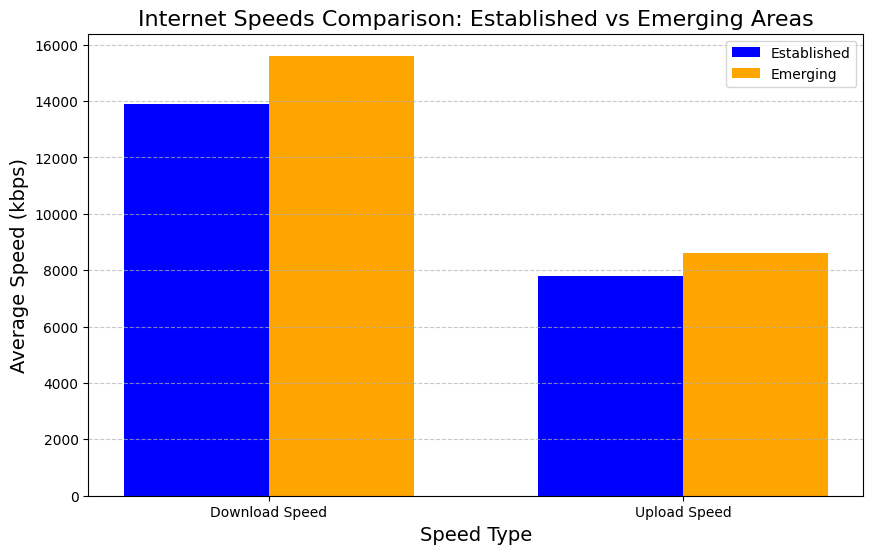

In [14]:
# Prepare data for the bar chart
categories = ['Download Speed', 'Upload Speed']
established_speeds = [established_avg_download, established_avg_upload]
emerging_speeds = [emerging_avg_download, emerging_avg_upload]

# Plot the comparison
fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.35
x = range(len(categories))

# Bar chart for Established and Emerging areas
ax.bar(x, established_speeds, bar_width, label='Established', color='blue')
ax.bar([p + bar_width for p in x], emerging_speeds, bar_width, label='Emerging', color='orange')

# Add labels and title
ax.set_title('Internet Speeds Comparison: Established vs Emerging Areas', fontsize=16)
ax.set_xlabel('Speed Type', fontsize=14)
ax.set_ylabel('Average Speed (kbps)', fontsize=14)
ax.set_xticks([p + bar_width / 2 for p in x])
ax.set_xticklabels(categories)

# Add legend and grid
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.show()

In [28]:
# Step 1: Simulate a 'date' column for the full dataset
# Create a date range from 2020-01-01 to 2023-01-31
date_range = pd.date_range(start='2020-01-01', end='2023-01-31', freq='D')

# Repeat the date range to match the length of the dataset
gdf['date'] = np.tile(date_range, len(gdf) // len(date_range) + 1)[:len(gdf)]

# Step 2: Group data by simulated date and area type to compute averages
trend_data = gdf.groupby(['date', 'area_type']).agg({
    'avg_d_kbps': 'mean',         # Average download speed
    'avg_u_kbps': 'mean',         # Average upload speed
    'log_light_intensity': 'mean' # Average log light intensity
}).reset_index()

# Step 3: Create separate datasets for Established and Emerging areas
established_trend = trend_data[trend_data['area_type'] == 'established']
emerging_trend = trend_data[trend_data['area_type'] == 'emerging']

# Ensure datasets include date and log_light_intensity
print("Established Trend Data:")
print(established_trend.head())

print("\nEmerging Trend Data:")
print(emerging_trend.head())

# Save the datasets if needed
established_trend.to_csv('established_trend.csv', index=False)
emerging_trend.to_csv('emerging_trend.csv', index=False)



Established Trend Data:
         date    area_type    avg_d_kbps    avg_u_kbps  log_light_intensity
1  2020-01-01  established  14711.111111   6625.888889             0.385971
3  2020-01-02  established  17941.500000  14865.500000             0.416970
6  2020-01-03  established  14973.666667   5522.111111             0.386518
9  2020-01-04  established  14332.571429   4975.571429             0.451631
12 2020-01-05  established  13919.000000   5092.777778             0.374583

Emerging Trend Data:
         date area_type  avg_d_kbps  avg_u_kbps  log_light_intensity
5  2020-01-03  emerging     12558.0      1937.0             0.048790
8  2020-01-04  emerging     23493.0     18027.0             0.039221
11 2020-01-05  emerging       727.0       627.0             0.029559
14 2020-01-06  emerging      7950.0      2411.0             0.029559
17 2020-01-07  emerging     30128.0     23903.0             0.048790


In [16]:
# Step 1: Define a function to detect and remove outliers based on IQR
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Step 2: Remove outliers from the trend data
trend_data_cleaned = remove_outliers(trend_data, 'avg_d_kbps')  # Remove outliers in download speeds
trend_data_cleaned = remove_outliers(trend_data_cleaned, 'avg_u_kbps')  # Remove outliers in upload speeds

# Split the cleaned trend data
established_trend_cleaned = trend_data_cleaned[trend_data_cleaned['area_type'] == 'established']
emerging_trend_cleaned = trend_data_cleaned[trend_data_cleaned['area_type'] == 'emerging']

print(established_trend_cleaned.describe())
print(emerging_trend_cleaned.describe())

                      date    avg_d_kbps    avg_u_kbps
count                   27     27.000000     27.000000
mean   2020-01-17 12:26:40  14108.395748   7582.174962
min    2020-01-01 00:00:00   9506.615385   4358.884615
25%    2020-01-11 12:00:00  11637.442085   5673.310039
50%    2020-01-18 00:00:00  14448.860870   7817.054893
75%    2020-01-24 12:00:00  16016.731506   8540.204981
max    2020-01-31 00:00:00  19629.197183  13029.701149
std                    NaN   3071.519544   2222.919096
                                date    avg_d_kbps    avg_u_kbps
count                             23     23.000000     23.000000
mean   2020-01-15 13:33:54.782608640  14509.321541   7691.395306
min              2020-01-01 00:00:00   8372.250000   3496.076923
25%              2020-01-09 12:00:00  12142.810150   4724.626055
50%              2020-01-15 00:00:00  14364.013986   6763.000000
75%              2020-01-22 12:00:00  16776.935524  10472.059759
max              2020-01-31 00:00:00  21061.416667

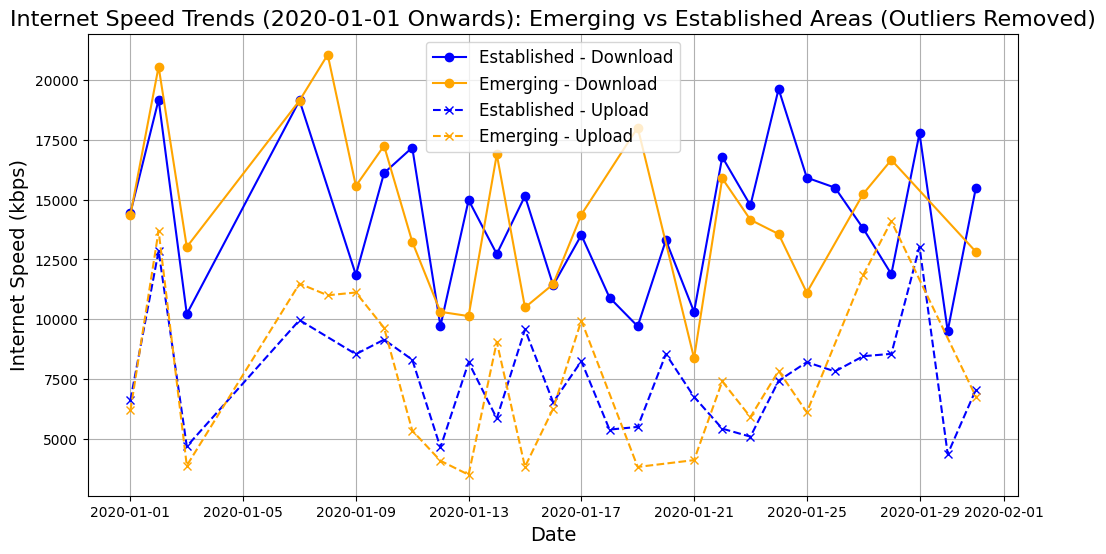

In [17]:
# Plot download speed trends (cleaned)
plt.figure(figsize=(12, 6))
plt.plot(established_trend_cleaned['date'], established_trend_cleaned['avg_d_kbps'], label='Established - Download', color='blue', linestyle='-', marker='o')
plt.plot(emerging_trend_cleaned['date'], emerging_trend_cleaned['avg_d_kbps'], label='Emerging - Download', color='orange', linestyle='-', marker='o')

# Plot upload speed trends (cleaned)
plt.plot(established_trend_cleaned['date'], established_trend_cleaned['avg_u_kbps'], label='Established - Upload', color='blue', linestyle='--', marker='x')
plt.plot(emerging_trend_cleaned['date'], emerging_trend_cleaned['avg_u_kbps'], label='Emerging - Upload', color='orange', linestyle='--', marker='x')

# Add titles, labels, and legend
plt.title('Internet Speed Trends (2020-01-01 Onwards): Emerging vs Established Areas (Outliers Removed)', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Internet Speed (kbps)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

# Show the plot
plt.show()

Pearson Correlation Coefficient: nan
Spearman Correlation Coefficient: nan


C:\Users\nasrr\AppData\Local\Temp\ipykernel_3100\1369938653.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_data = gdf.groupby('area_type', group_keys=False).apply(


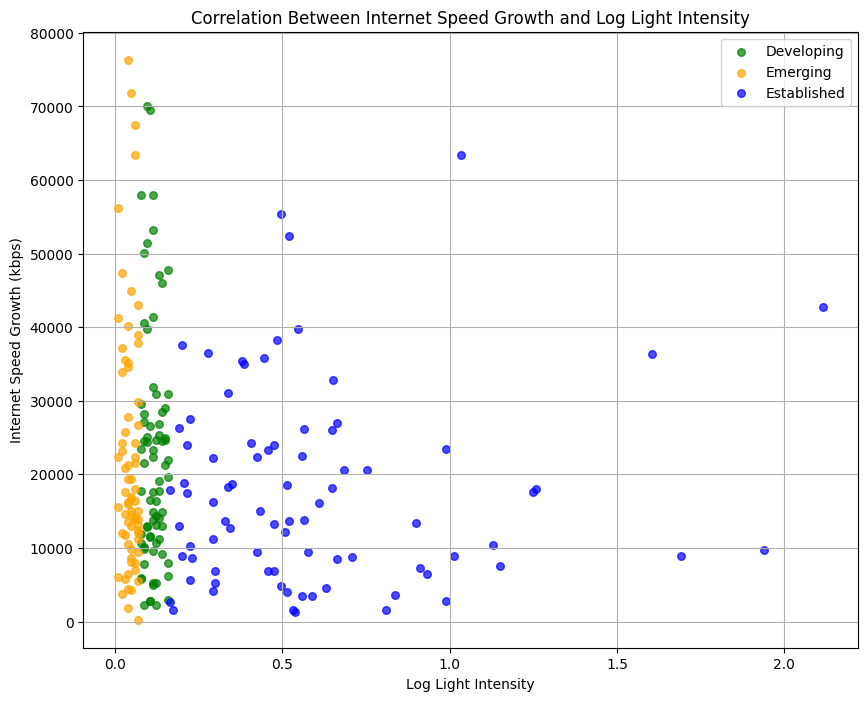

In [18]:
from scipy.stats import pearsonr, spearmanr

# Step 0: Calculate Internet Speed Growth
def calculate_internet_speed_growth(data):
    if 'avg_d_kbps' in data.columns and 'avg_u_kbps' in data.columns:
        data['internet_speed_growth'] = data['avg_d_kbps'] + data['avg_u_kbps']
    else:
        raise KeyError("The required columns ('avg_d_kbps', 'avg_u_kbps') are missing.")
    return data

# Step 1: Remove 'unknown' area types
def remove_unknown(data):
    return data[data['area_type'].notna() & (data['area_type'] != 'unknown')]

# Step 2: Sample Data Proportionally
def sample_data_proportionally(gdf, sample_size_per_group=500):
    sampled_data = gdf.groupby('area_type', group_keys=False).apply(
        lambda x: x.sample(min(len(x), sample_size_per_group), random_state=42)
    )
    return sampled_data

# Step 3: Remove Outliers
def remove_outliers(data, column, threshold=80000):
    return data[data[column] <= threshold]

# Step 4: Statistical Analysis
def calculate_correlation(data, x_column, y_column):
    pearson_corr, _ = pearsonr(data[x_column], data[y_column])
    spearman_corr, _ = spearmanr(data[x_column], data[y_column])
    return pearson_corr, spearman_corr

# Step 5: Scatter Plot
def plot_scatter(data, x_column, y_column):
    colors = {'established': 'blue', 'developing': 'green', 'emerging': 'orange'}
    plt.figure(figsize=(10, 8))
    for area_type, group_data in data.groupby('area_type'):
        plt.scatter(group_data[x_column], group_data[y_column], 
                    label=area_type.capitalize(), alpha=0.7, s=30, color=colors.get(area_type, 'gray'))
    plt.title("Correlation Between Internet Speed Growth and Log Light Intensity")
    plt.xlabel("Log Light Intensity")
    plt.ylabel("Internet Speed Growth (kbps)")
    plt.legend()
    plt.grid(True)
    plt.show()

# Execution
# Assume `gdf` is the DataFrame with necessary columns: 'area_type', 'log_light_intensity', 'avg_d_kbps', 'avg_u_kbps'

# Step 0: Calculate Internet Speed Growth
gdf = calculate_internet_speed_growth(gdf)

# Step 1: Remove unknown area types
cleaned_data = remove_unknown(gdf)

# Step 2: Sample the data
sampled_data = sample_data_proportionally(cleaned_data, sample_size_per_group=100)

# Step 3: Remove outliers
filtered_data = remove_outliers(sampled_data, column='internet_speed_growth', threshold=80000)

# Step 4: Calculate correlation
pearson_corr, spearman_corr = calculate_correlation(filtered_data, x_column='log_light_intensity', y_column='internet_speed_growth')

# Print Correlation Coefficients
print(f"Pearson Correlation Coefficient: {pearson_corr}")
print(f"Spearman Correlation Coefficient: {spearman_corr}")

# Step 5: Plot the scatter
plot_scatter(filtered_data, x_column='log_light_intensity', y_column='internet_speed_growth')


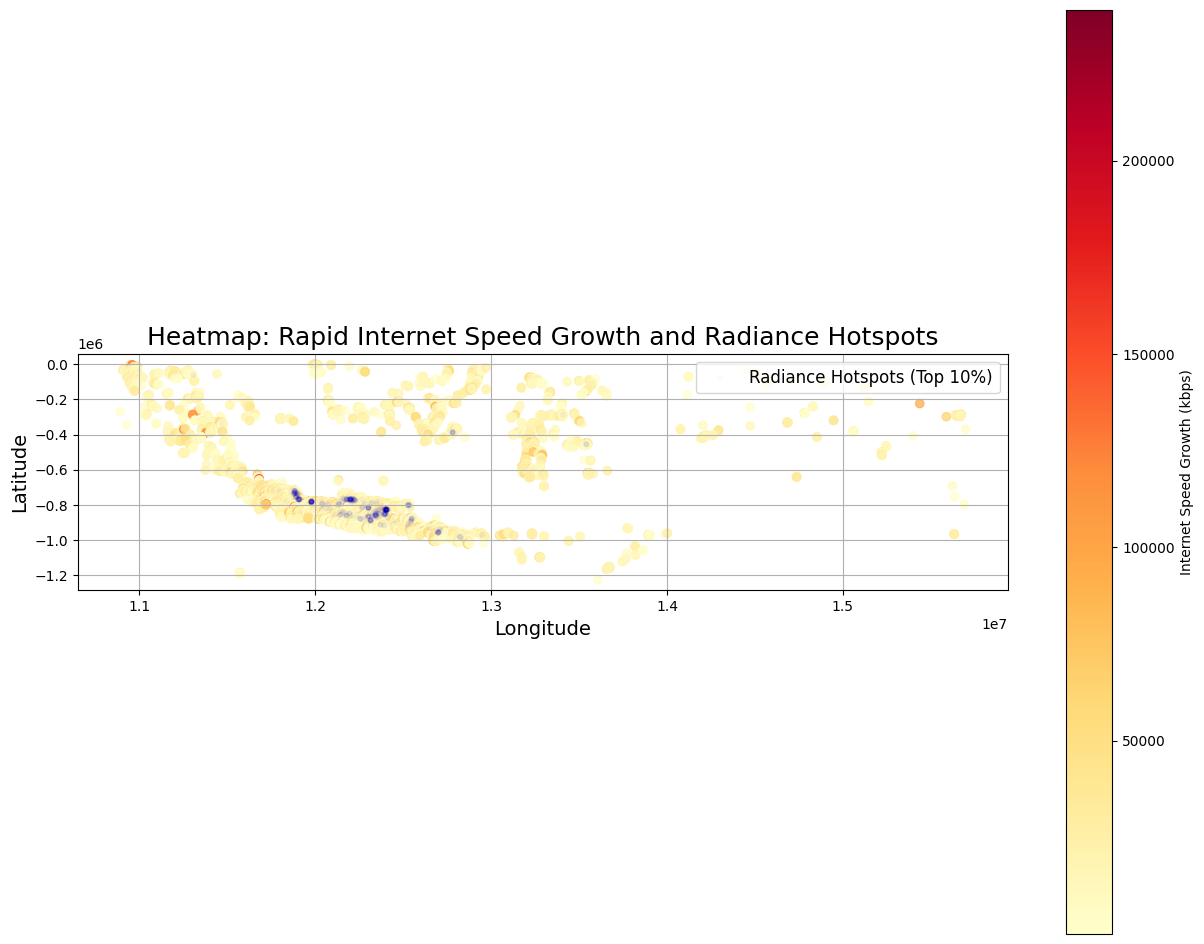

In [19]:
import geopandas as gpd
import matplotlib.pyplot as plt

def plot_internet_radiance_heatmap(gdf):
    # Ensure required columns exist
    gdf['internet_speed_growth'] = gdf['avg_d_kbps'] + gdf['avg_u_kbps']
    
    # Define figure size and plot internet speed growth heatmap
    fig, ax = plt.subplots(figsize=(15, 12))
    
    # Plot internet speed growth as the heatmap
    gdf.plot(
        ax=ax,
        column='internet_speed_growth',
        cmap='YlOrRd',
        legend=True,
        legend_kwds={'label': "Internet Speed Growth (kbps)"},
        alpha=0.7
    )
    
    # Overlay radiance growth hotspots
    radiance_hotspots = gdf[gdf['log_light_intensity'] > gdf['log_light_intensity'].quantile(0.9)]  # Top 10% radiance
    radiance_hotspots.plot(
        ax=ax,
        color='blue',
        markersize=10,
        label='Radiance Hotspots (Top 10%)',
        alpha=0.01
    )
    
    # Add titles, labels, and legend
    ax.set_title("Heatmap: Rapid Internet Speed Growth and Radiance Hotspots", fontsize=18)
    ax.set_xlabel("Longitude", fontsize=14)
    ax.set_ylabel("Latitude", fontsize=14)
    ax.legend(fontsize=12, loc='upper right')
    ax.grid(True)
    
    # Show the heatmap with overlay
    plt.show()

# Call the function
plot_internet_radiance_heatmap(gdf_internet_speed)


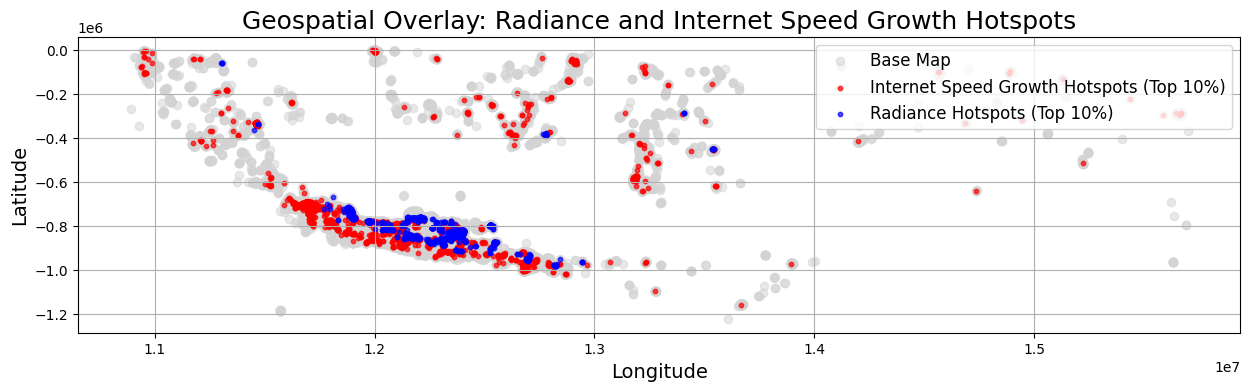

In [20]:
import geopandas as gpd
import matplotlib.pyplot as plt

def plot_geospatial_overlay(gdf):
    # Ensure required columns exist
    gdf['internet_speed_growth'] = gdf['avg_d_kbps'] + gdf['avg_u_kbps']

    # Define thresholds for hotspots
    internet_speed_threshold = gdf['internet_speed_growth'].quantile(0.9)  # Top 10% internet speed growth
    radiance_threshold = gdf['log_light_intensity'].quantile(0.9)  # Top 10% radiance
    
    # Identify internet speed growth hotspots
    internet_speed_hotspots = gdf[gdf['internet_speed_growth'] > internet_speed_threshold]
    
    # Identify radiance hotspots
    radiance_hotspots = gdf[gdf['log_light_intensity'] > radiance_threshold]
    
    # Define figure size and base map
    fig, ax = plt.subplots(figsize=(15, 12))
    gdf.plot(
        ax=ax,
        color='lightgrey',
        alpha=0.5,
        label='Base Map'
    )
    
    # Plot internet speed growth hotspots
    internet_speed_hotspots.plot(
        ax=ax,
        color='red',
        markersize=10,
        label='Internet Speed Growth Hotspots (Top 10%)',
        alpha=0.7
    )
    
    # Plot radiance hotspots
    radiance_hotspots.plot(
        ax=ax,
        color='blue',
        markersize=10,
        label='Radiance Hotspots (Top 10%)',
        alpha=0.7
    )
    
    # Add titles, labels, and legend
    ax.set_title("Geospatial Overlay: Radiance and Internet Speed Growth Hotspots", fontsize=18)
    ax.set_xlabel("Longitude", fontsize=14)
    ax.set_ylabel("Latitude", fontsize=14)
    ax.legend(fontsize=12, loc='upper right')
    ax.grid(True)
    
    # Show the overlay map
    plt.show()

# Call the function
plot_geospatial_overlay(gdf_internet_speed)


In [21]:
from scipy.stats import ttest_ind

def perform_hypothesis_testing(gdf):
    # Subset the data
    emerging = gdf[gdf['area_type'] == 'emerging']['internet_speed_growth']
    established = gdf[gdf['area_type'] == 'established']['internet_speed_growth']
    
    # Perform t-test (two-sided, unequal variances)
    t_stat, p_value = ttest_ind(emerging, established, equal_var=False)
    
    # Interpret results
    print("Hypothesis Testing Results:")
    print(f"T-Statistic: {t_stat:.4f}")
    print(f"P-Value: {p_value:.4f}")
    
    if p_value < 0.05:
        print("Reject the Null Hypothesis: Internet speed growth rates differ between emerging and established urban areas.")
    else:
        print("Fail to Reject the Null Hypothesis: No significant difference in internet speed growth rates.")

# Call the function
perform_hypothesis_testing(gdf_internet_speed)




Hypothesis Testing Results:
T-Statistic: 4.4473
P-Value: 0.0000
Reject the Null Hypothesis: Internet speed growth rates differ between emerging and established urban areas.


In [22]:
import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency

def perform_chi_square_test(gdf):
    # Step 1: Discretize 'internet_speed_growth' into categories (e.g., low, medium, high)
    bins = [-np.inf, gdf['internet_speed_growth'].quantile(0.33),
            gdf['internet_speed_growth'].quantile(0.66), np.inf]
    labels = ['Low', 'Medium', 'High']
    gdf['speed_growth_category'] = pd.cut(gdf['internet_speed_growth'], bins=bins, labels=labels)

    # Step 2: Create a contingency table
    contingency_table = pd.crosstab(gdf['area_type'], gdf['speed_growth_category'])
    print("Contingency Table:")
    print(contingency_table)

    # Step 3: Perform the Chi-Square test
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    # Step 4: Interpret results
    print("\nChi-Square Test Results:")
    print(f"Chi-Square Statistic: {chi2:.4f}")
    print(f"P-Value: {p:.4f}")
    print(f"Degrees of Freedom: {dof}")
    print("Expected Frequencies:")
    print(expected)

    if p < 0.05:
        print("Reject the Null Hypothesis: There is a significant association between area type and internet speed growth categories.")
    else:
        print("Fail to Reject the Null Hypothesis: No significant association between area type and internet speed growth categories.")

# Call the function
perform_chi_square_test(gdf_internet_speed)

Contingency Table:
speed_growth_category   Low  Medium  High
area_type                                
developing              768     865   779
emerging                462     518   512
established            3314    2534  2419

Chi-Square Test Results:
Chi-Square Statistic: 85.4816
P-Value: 0.0000
Degrees of Freedom: 4
Expected Frequencies:
[[ 900.51170816  776.2553611   735.23293074]
 [ 557.03294717  480.17122669  454.79582614]
 [3086.45534467 2660.57341221 2519.97124312]]
Reject the Null Hypothesis: There is a significant association between area type and internet speed growth categories.


Established Areas:
Established Areas Model Results:
Mean Squared Error (MSE): 4095977.70
R-squared (R²): 33.97%


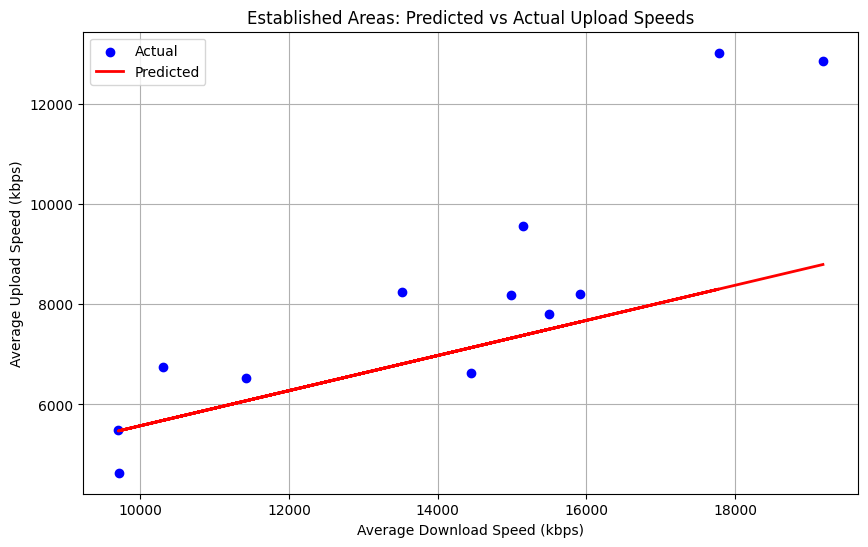


Emerging Areas:
Emerging Areas Model Results:
Mean Squared Error (MSE): 4095977.70
R-squared (R²): 33.97%


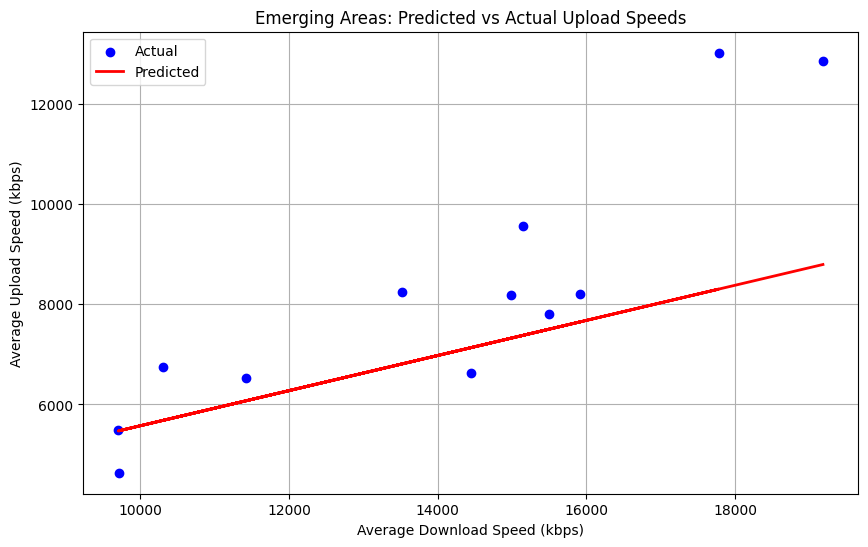

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Function to train and evaluate a linear regression model
def train_and_evaluate(data, label):
    # Features (X) and Target (y)
    X = data[['avg_d_kbps']].values  # Independent variable: Average download speed
    y = data['avg_u_kbps'].values    # Dependent variable: Average upload speed

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

    # Create and train the model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Predictions
    y_pred = model.predict(X_test)

    # Evaluation Metrics
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"{label} Model Results:")
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"R-squared (R²): {r2 * 100:.2f}%")

    # Visualization
    plt.figure(figsize=(10, 6))
    plt.scatter(X_test, y_test, color='blue', label='Actual')
    plt.plot(X_test, y_pred, color='red', linewidth=2, label='Predicted')
    plt.title(f'{label}: Predicted vs Actual Upload Speeds')
    plt.xlabel('Average Download Speed (kbps)')
    plt.ylabel('Average Upload Speed (kbps)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Train and evaluate models for established and emerging trends
print("Established Areas:")
train_and_evaluate(established_trend, "Established Areas")

print("\nEmerging Areas:")
train_and_evaluate(established_trend, "Emerging Areas")


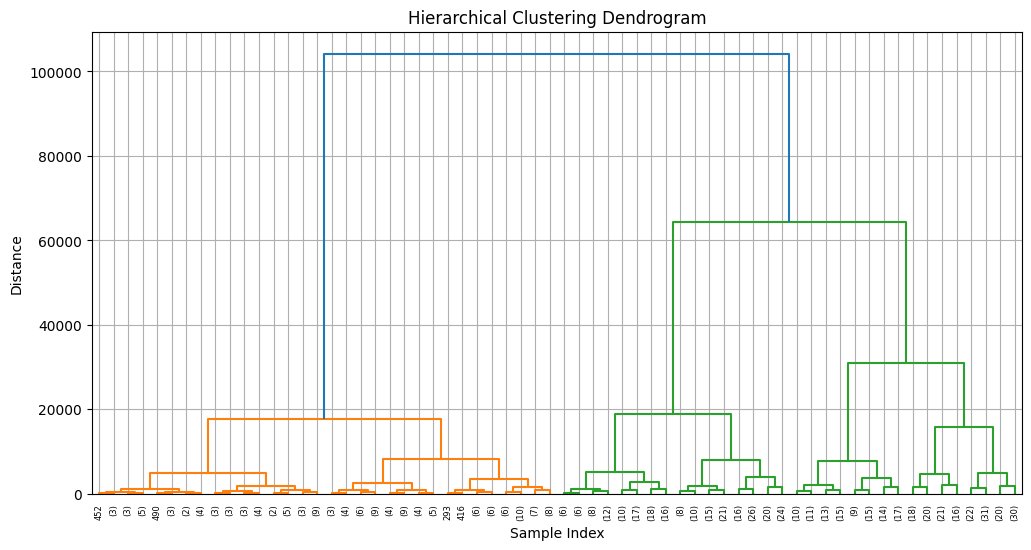

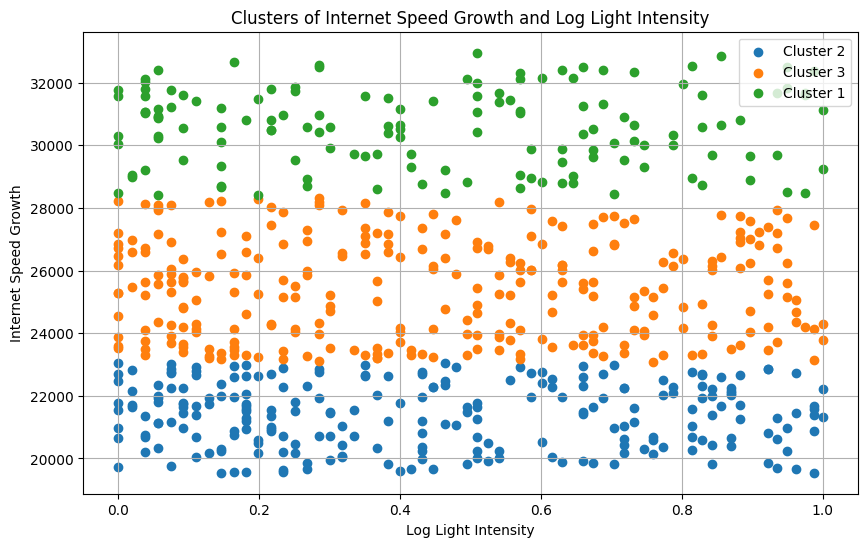

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster

# Step 1: Remove NaNs and outliers
def preprocess_data(data):
    # Remove NaN values
    data = data.dropna(subset=['log_light_intensity', 'internet_speed_growth'])
    
    # Remove outliers
    lower_bound = data['internet_speed_growth'].quantile(0.01)
    upper_bound = data['internet_speed_growth'].quantile(0.99)
    data = data[(data['internet_speed_growth'] >= lower_bound) & 
                (data['internet_speed_growth'] <= upper_bound)]
    return data

# Step 2: Perform Hierarchical Clustering
def perform_clustering(data, features, num_clusters=3):
    # Use Ward's method to perform hierarchical clustering
    linkage_matrix = linkage(data[features], method='ward')
    
    # Plot dendrogram
    plt.figure(figsize=(12, 6))
    dendrogram(linkage_matrix, truncate_mode='level', p=5)
    plt.title("Hierarchical Clustering Dendrogram")
    plt.xlabel("Sample Index")
    plt.ylabel("Distance")
    plt.grid(True)
    plt.show()
    
    # Assign clusters to data
    data['cluster'] = fcluster(linkage_matrix, num_clusters, criterion='maxclust')
    return data

# Step 3: Visualize Clusters
def visualize_clusters(data, features, cluster_column='cluster'):
    plt.figure(figsize=(10, 6))
    for cluster in data[cluster_column].unique():
        cluster_data = data[data[cluster_column] == cluster]
        plt.scatter(cluster_data[features[0]], cluster_data[features[1]], label=f"Cluster {cluster}")
    plt.title("Clusters of Internet Speed Growth and Log Light Intensity")
    plt.xlabel(features[0].replace('_', ' ').title())
    plt.ylabel(features[1].replace('_', ' ').title())
    plt.legend()
    plt.grid()
    plt.show()

# Execution
# Preprocess the data
processed_data = preprocess_data(gdf)

# Perform hierarchical clustering
clustered_data = perform_clustering(
    data=processed_data,
    features=['log_light_intensity', 'internet_speed_growth'],
    num_clusters=3
)

# Visualize the resulting clusters
visualize_clusters(
    data=clustered_data,
    features=['log_light_intensity', 'internet_speed_growth']
)


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Step 1: Assume `clusters` contains cluster labels (from previous clustering code)
# Ensure the cluster labels correspond to the original dataset `df` (or `gdf`)
df['cluster_label'] = clustered_data  # Add cluster labels to the dataset

# Step 2: Iterate through each cluster
cluster_models = {}
cluster_results = []

for cluster in df['cluster_label'].unique():
    print(f"Processing Cluster {cluster}")
    
    # Subset data for the current cluster
    cluster_data = df[df['cluster_label'] == cluster]
    X = cluster_data[['log_light_intensity']].values  # Use relevant features
    y = cluster_data['internet_speed_growth'].values
    
    # Remove NaN values
    valid_indices = ~np.isnan(X).flatten() & ~np.isnan(y)
    X = X[valid_indices]
    y = y[valid_indices]
    
    if len(X) == 0 or len(y) == 0:
        print(f"Skipping Cluster {cluster} due to lack of valid data.")
        continue

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Train the model
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Predict on test data
    y_pred = model.predict(X_test)
    
    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"Cluster {cluster} - Mean Squared Error (MSE): {mse:.2f}")
    print(f"Cluster {cluster} - R-squared (R²): {r2 * 100:.2f}%")
    
    # Store the model and results
    cluster_models[cluster] = model
    cluster_results.append({'cluster': cluster, 'mse': mse, 'r2': r2})
    
    # Visualize results
    plt.figure(figsize=(8, 6))
    plt.scatter(X_test, y_test, color='blue', label='Actual')
    plt.plot(X_test, y_pred, color='red', linewidth=2, label='Predicted')
    plt.title(f'Cluster {cluster}: Predicted vs Actual')
    plt.xlabel('Log Light Intensity')
    plt.ylabel('Internet Speed Growth (kbps)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Step 3: Summarize results for all clusters
results_df = pd.DataFrame(cluster_results)
print("Cluster-wise Results:")
print(results_df)


NameError: name 'clusters' is not defined